# Gesture Recognition

Build a Model to recognise five different gestures performed by the user.

Thumbs up:  Increase the volume    
Thumbs down: Decrease the volume    
Left swipe: 'Jump' backwards 10 seconds     
Right swipe: 'Jump' forward 10 seconds   
Stop: Pause the movie 

In [1]:
import numpy as np
import os
from  skimage.transform import resize
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

Get the datset from shared Google Drive and store in local storage

In [3]:
import gdown
url = 'https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
To: /content/dataset.zip
100%|██████████| 1.71G/1.71G [00:08<00:00, 197MB/s]


'dataset.zip'

In [4]:
!unzip -qqo 'dataset.zip' 

In [5]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())


## Analysis of Video Frames for Image Idx

Get the one folder for each class and plot the frames to Analyze for which image Indexes are most important and useful

In [6]:
class_folders=[] #get one folder for eac class of gesture 
for i in range(5):
  for folders in train_doc:
    if folders.split(";")[2]==f'{i}\n':
      class_folders.append(folders.split(";")[0])
      break


In [7]:
# fig, axes = plt.subplots(30,5,sharex=True,sharey=True,figsize=(20,50),dpi=50)
# for class_id, each_uniue_folder in enumerate(class_folders):
#   images = os.listdir(f'Project_data/train/{each_uniue_folder}')
#   images=sorted(images)
#   for id,image in enumerate(images):
#     img = mpimg.imread(f'Project_data/train/{each_uniue_folder}/{image}')
#     axes[id,class_id].imshow(img)
# fig.show()


### Observations

As per above images, we can see there is very slight changes in movement of hands from one frame to next frame.

We will will take one frame for evry 4 consecutive ones.

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
from google.colab.patches import cv2_imshow

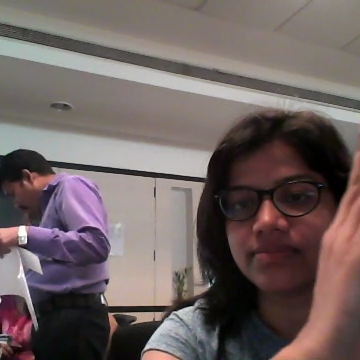

In [9]:
image = cv2.imread('/content/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png')
cv2_imshow(image)


In [10]:
image.shape

(360, 360, 3)

In [11]:
image = cv2.resize(image,(35,35))

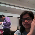

In [12]:
cv2_imshow(image)

In [13]:
no_of_frames =len( np.append(np.arange(0,30,step=4),29))

In [14]:
def generator(source_path, folder_list, batch_size, image_resize_dim, img_idx, sort='no'):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx
    x, y, z = len(img_idx), *image_resize_dim   
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(np.ceil(len(folder_list)/batch_size))
        for batch in range(num_batches): # we iterate over the number of batches
            # create act_batch_size to handle the remaining data points in last batch if total data points is not multiple of batch size
            if(batch == (num_batches-1)):
              act_batch_size = len(folder_list) - (batch*batch_size)
            else:
              act_batch_size = batch_size
            batch_data = np.zeros((act_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((act_batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(act_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*act_batch_size)].split(';')[0]) # read all the images in the folder
                if(sort=='yes'):
                  imgs = sorted(imgs)  # sort the images in folder for timewise sequence
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in                      
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*act_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image, image_resize_dim)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*act_batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [16]:
print(len(np.append(np.arange(0,30,step=2),29)))

16


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, SimpleRNN, LSTM
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import ResNet50

Let us create the model checkpoints and Learning rate callbacks

In [18]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [19]:
def get_steps_per_epoch(batch_size):
  if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1
  return steps_per_epoch, validation_steps

Let us now create the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Model 1: Conv3D - 100*100 - Batch Size 10

In [20]:
image_resize_dim=(100,100)
batch_size = 10
img_idx = np.append(np.arange(0,30,step=4),29) 
train_generator = generator(train_path, train_doc, batch_size,image_resize_dim, img_idx)
val_generator = generator(val_path, val_doc, batch_size,image_resize_dim, img_idx)
steps_per_epoch, validation_steps = get_steps_per_epoch(batch_size)


model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',  input_shape=(no_of_frames,*image_resize_dim,3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())


model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.SGD() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience= 2, min_lr=0.001)
callbacks_list = [ LR]
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                      validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 7, 98, 98, 64)     5248      
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 96, 96, 64)     110656    
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 94, 94, 128)    221312    
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 47, 47, 128)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 47, 47, 128)    0         
                                                                 
 flatten (Flatten)           (None, 282752)            0         
                                                        

## Model 2: Conv3D - - 100*100 - Batch Size 10 - with sort images in generator


In [21]:
image_resize_dim=(100,100)
batch_size = 10
img_idx = np.append(np.arange(0,30,step=4),29) 
train_generator = generator(train_path, train_doc, batch_size,image_resize_dim, img_idx, 'yes')
val_generator = generator(val_path, val_doc, batch_size,image_resize_dim, img_idx,'yes')
steps_per_epoch, validation_steps = get_steps_per_epoch(batch_size)


model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',  input_shape=(no_of_frames,*image_resize_dim,3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())


model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.SGD() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience= 2, min_lr=0.001)
callbacks_list = [ LR]
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                      validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 7, 98, 98, 64)     5248      
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 96, 96, 64)     110656    
                                                                 
 conv3d_5 (Conv3D)           (None, 3, 94, 94, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 47, 47, 128)   0         
 3D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 47, 47, 128)    0         
                                                                 
 flatten_1 (Flatten)         (None, 282752)            0         
                                                      

## Model 3: Conv3D - - 100*100 - Batch Size 50 - with sort images in generator

In [22]:
image_resize_dim=(100,100)
batch_size = 50
img_idx = np.append(np.arange(0,30,step=4),29) 
train_generator = generator(train_path, train_doc, batch_size,image_resize_dim, img_idx, 'yes')
val_generator = generator(val_path, val_doc, batch_size,image_resize_dim, img_idx,'yes')
steps_per_epoch, validation_steps = get_steps_per_epoch(batch_size)


model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',  input_shape=(no_of_frames,*image_resize_dim,3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())


model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.SGD() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience= 2, min_lr=0.001)
callbacks_list = [ LR]
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                      validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 7, 98, 98, 64)     5248      
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 96, 96, 64)     110656    
                                                                 
 conv3d_8 (Conv3D)           (None, 3, 94, 94, 128)    221312    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 47, 47, 128)   0         
 3D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 1, 47, 47, 128)    0         
                                                                 
 flatten_2 (Flatten)         (None, 282752)            0         
                                                      

## Model 4: CNN- RNN Model using SimpleRNN


In [26]:
image_resize_dim=(100,100)
batch_size = 10
img_idx = np.append(np.arange(0,30,step=4),29) 
train_generator = generator(train_path, train_doc, batch_size,image_resize_dim, img_idx, 'yes')
val_generator = generator(val_path, val_doc, batch_size,image_resize_dim, img_idx,'yes')
steps_per_epoch, validation_steps = get_steps_per_epoch(batch_size)

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(*image_resize_dim,3))
cnn =Sequential([resnet])
cnn.add(Conv2D(64,(2,2),strides=(1,1)))
cnn.add(Flatten())
rnn_model = Sequential()
rnn_model.add(TimeDistributed(cnn,input_shape=(no_of_frames,*image_resize_dim,3)))
rnn_model.add(SimpleRNN(32,return_sequences=True))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(5,activation='softmax'))
optimiser = optimizers.SGD() 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                            patience= 2, min_lr=0.002)
rnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (rnn_model.summary())

rnn_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                  callbacks=[ checkpoint,LR], validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 9, 576)           24112064  
 tributed)                                                       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 9, 32)             19488     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 5)                 165       
                                                                 
Total params: 24,133,797
Trainable params: 24,080,677
Non-trainable params: 53,120
_________________________________________________________________
None
Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 [===========================

### Model 5 - LSTM

In [28]:
image_resize_dim=(100,100)
batch_size = 10
img_idx = np.append(np.arange(0,30,step=4),29) 
train_generator = generator(train_path, train_doc, batch_size,image_resize_dim, img_idx, 'yes')
val_generator = generator(val_path, val_doc, batch_size,image_resize_dim, img_idx,'yes')
steps_per_epoch, validation_steps = get_steps_per_epoch(batch_size)

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(*image_resize_dim,3))
cnn =Sequential([resnet])
cnn.add(Conv2D(64,(2,2),strides=(1,1)))
cnn.add(Flatten())
lstm_model = Sequential()
lstm_model.add(TimeDistributed(cnn,input_shape=(no_of_frames,*image_resize_dim,3)))
lstm_model.add(LSTM(32,return_sequences=True))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(5,activation='softmax'))
optimiser = optimizers.SGD() 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                            patience= 2, min_lr=0.002)
lstm_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (lstm_model.summary())

lstm_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                  callbacks=[ LR], validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 9, 576)           24112064  
 tributed)                                                       
                                                                 
 lstm_4 (LSTM)               (None, 9, 32)             77952     
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                                 
Total params: 24,198,501
Trainable params: 24,145,381
Non-trainable params: 53,120
_________________________________________________________________
None
Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 [===========================

## Model 6: GRU

In [29]:
image_resize_dim=(100,100)
batch_size = 10
img_idx = np.append(np.arange(0,30,step=4),29) 
train_generator = generator(train_path, train_doc, batch_size,image_resize_dim, img_idx, 'yes')
val_generator = generator(val_path, val_doc, batch_size,image_resize_dim, img_idx,'yes')
steps_per_epoch, validation_steps = get_steps_per_epoch(batch_size)

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(*image_resize_dim,3))
cnn =Sequential([resnet])
cnn.add(Conv2D(64,(2,2),strides=(1,1)))
cnn.add(Flatten())
gru_model = Sequential()
gru_model.add(TimeDistributed(cnn,input_shape=(no_of_frames,*image_resize_dim,3)))
gru_model.add(GRU(32,return_sequences=True))
gru_model.add(GRU(32))
gru_model.add(Dense(5,activation='softmax'))
optimiser = optimizers.SGD(learning_rate=0.008) 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                            patience= 2, min_lr=0.002)
gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (gru_model.summary())

gru_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                  callbacks=[ LR], validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 9, 576)           24112064  
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 9, 32)             58560     
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense_12 (Dense)            (None, 5)                 165       
                                                                 
Total params: 24,177,125
Trainable params: 24,124,005
Non-trainable params: 53,120
_________________________________________________________________
None
Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 [===========================

# Final Model

In [30]:
image_resize_dim=(100,100)
batch_size = 10
img_idx = np.append(np.arange(0,30,step=4),29) 
train_generator = generator(train_path, train_doc, batch_size,image_resize_dim, img_idx, 'yes')
val_generator = generator(val_path, val_doc, batch_size,image_resize_dim, img_idx,'yes')
steps_per_epoch, validation_steps = get_steps_per_epoch(batch_size)

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(*image_resize_dim,3))
cnn =Sequential([resnet])
cnn.add(Conv2D(64,(2,2),strides=(1,1)))
cnn.add(Flatten())
rnn_model = Sequential()
rnn_model.add(TimeDistributed(cnn,input_shape=(no_of_frames,*image_resize_dim,3)))
rnn_model.add(SimpleRNN(32,return_sequences=True))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(5,activation='softmax'))
optimiser = optimizers.SGD() 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                            patience= 2, min_lr=0.002)
rnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (rnn_model.summary())

rnn_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                  callbacks=[ checkpoint,LR], validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 9, 576)           24112064  
 tributed)                                                       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 9, 32)             19488     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 5)                 165       
                                                                 
Total params: 24,133,797
Trainable params: 24,080,677
Non-trainable params: 53,120
_________________________________________________________________
None
Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 [===========================